In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms
import math

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# An overview of the dataset
'user_id' = user ID for the session <br>
'timestamp' = timestamp for the session <br>
'group' = control and treatment groups, where control group was shown the old design, and treatment group was shown the new design <br>
'landing_page' = the design of the website (old or new) viewed by the user <br>
'converted' = user's behavior, where 0: user did not make a purchase, and 1: user made a purchase 

In [2]:
# Load the dataset from Github
df = pd.read_csv('https://raw.githubusercontent.com/shihuitay/Datasets/main/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [5]:
# Check for missing values
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [6]:
# Check for repeated user id
df[df.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0
7500,899953,2017-01-07 03:06:54.068237,control,new_page,0
8036,790934,2017-01-19 08:32:20.329057,treatment,new_page,0
10218,633793,2017-01-17 00:16:00.746561,treatment,old_page,0
...,...,...,...,...,...
294308,905197,2017-01-03 06:56:47.488231,treatment,new_page,0
294309,787083,2017-01-17 00:15:20.950723,control,old_page,0
294328,641570,2017-01-09 21:59:27.695711,control,old_page,0
294331,689637,2017-01-13 11:34:28.339532,control,new_page,0


There are 3894 repeated user ID (rows). Since they constitutes less than 1.5% of the dataset, we proceed with removing them.

In [7]:
# Check whether the number of treatment group == new_page
a = [len(df[df['group']=='treatment'])]
b = [len(df[df['landing_page']=='new_page'])]
print(a==b)

False


The number of treatment group does not match with the number of new_page. So, we have to remove the rows where treatment group does not match with new_page.

In [8]:
# Identify the index of rows where treatment group does not match with new_page
i = df[((df['group']=='treatment') ==(df['landing_page']=='new_page')) == False].index
# Remove these rows
df.drop(i, inplace=True)

In [9]:
# Let's visualize the cleaned dataset
ct = pd.crosstab(df['group'], df['landing_page'])
ct

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


In [10]:
stacked = ct.stack().reset_index().rename(columns={0:'value'})
stacked

,group,landing_page,value
0,control,new_page,0
1,control,old_page,145274
2,treatment,new_page,145311
3,treatment,old_page,0


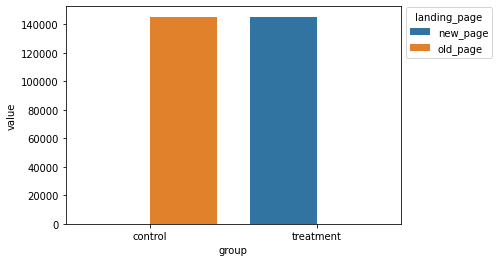

In [11]:
p = sns.barplot(x=stacked.group, y=stacked.value, hue=stacked.landing_page, order=['control', 'treatment'])
sns.move_legend(p, bbox_to_anchor=(1, 1.02), loc='upper left')

Now the data looks pretty neat!

## Choosing a Sample Size

Assuming that the conversion rate (purchased) was originally 12%. We would like to increase this number to 14%.

In [13]:
effect_size = sms.proportion_effectsize(0.12, 0.14)    # calcute the effect size (the difference we expect there to be between the conversion rates)

sample_size = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, # power of the test (1 — β)
    alpha=0.05, # the critical value; this means that the confidence interval, CI is 95%
    ratio=1 # ratio of the number of observations in sample 2 relative to sample 1
    )                                                

# The required sample size
n = round(sample_size)
print(n)

4432


Hence we need at least 4432 observations for each group.

## Sampling

In [14]:
# Perform sampling based on the sample size calculated
control = df[df['group'] == 'control'].sample(n=n, random_state=888)
treatment = df[df['group'] == 'treatment'].sample(n=n, random_state=888)

# Create a new dataframe for a/b testing
ab_test = pd.concat([control, treatment], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,942482,2017-01-22 23:46:25.728153,control,old_page,0
1,852240,2017-01-02 17:34:35.171214,control,old_page,0
2,888334,2017-01-05 12:44:44.194274,control,old_page,0
3,881694,2017-01-20 21:12:38.438734,control,old_page,0
4,635297,2017-01-20 03:20:15.708307,control,old_page,0
...,...,...,...,...,...
8859,882610,2017-01-07 16:17:02.395139,treatment,new_page,0
8860,915775,2017-01-11 06:40:28.169543,treatment,new_page,1
8861,819183,2017-01-18 21:27:39.662728,treatment,new_page,0
8862,794480,2017-01-22 05:29:01.585711,treatment,new_page,1


In [15]:
# Check if control = treatment = 4432
ab_test['group'].value_counts()

control      4432
treatment    4432
Name: group, dtype: int64

## Visualize the samples and perform statistical analysis

In [16]:
conversion_rates = ab_test.groupby('group')['converted']
std_p = lambda x: np.std(x, ddof=0)              # std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'standard_deviation', 'standard_error']

conversion_rates.style.format('{:.4f}')

,conversion_rate,standard_deviation,standard_error
group,,,
control,0.1241,0.3297,0.0050
treatment,0.1232,0.3287,0.0049


(0.0, 0.15)

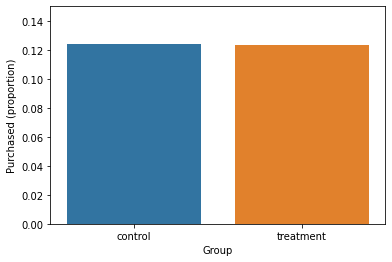

In [17]:
sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)
plt.xlabel('Group')
plt.ylabel('Purchased (proportion)')
plt.ylim(0, 0.15)

## Hypothesis Testing

### Two-tailed test:
Null hypothesis, H0: p = p1 (There is no difference in the conversion rate/number of purchase before and after the new website design) <br>
Alternative hypothesis, H1: p ≠ p1 (There is significant difference in the conversion rate/number of purchase before and after the new website design)

In [18]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_purchased = ab_test[ab_test['group'] == 'control']['converted']
treatment_purchased = ab_test[ab_test['group'] == 'treatment']['converted']

In [19]:
purchased = [control_purchased.sum(), treatment_purchased.sum()]

z_stat, pval = proportions_ztest(purchased, nobs=[n,n])
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(purchased, nobs=[n,n], alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.13
p-value: 0.897
CI 95% for control group: [0.114, 0.134]
CI 95% for treatment group: [0.114, 0.133]


## Conclusion

* Since the p-value=0.897 is more than α=0.05, we do not reject the null 
hypothesis. 
* The CI for the treatment group, [0.114, 0.133], did not include the target value of 14%.
* In other words, the new website design did not result in a difference in the conversion rate (number of purchase).